# 从手写识别了解卷积神经网络

### 简介：

<font size=3>
  
  本项目通过简介卷积神经网络（什么是卷积神经网络，怎么样理解，怎么样计算）然后使用飞桨高级API完成卷积神经网络的手写数字识别来带大家一起学习神经网络

### 1、图像分类原理

<font size=3>
  
<img src="https://img-blog.csdnimg.cn/20210205110146390.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80NTYyMzA5Mw==,size_16,color_FFFFFF,t_70" width="55%">

**计算机的视角：**
  <img src="https://img-blog.csdnimg.cn/20210205110253582.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80NTYyMzA5Mw==,size_16,color_FFFFFF,t_70" width="50%">  

一张彩色的图片涉及到了一个通道的问题，彩色的是三通道，代表着这个图里面的c（相对应第三维度的值）  
这里面的w，h相对应图片的宽度和高度，就是传说中的像素比如（28*28）（800*800）  

白话：  
>这个东西这么理解呢，说实话很抽象，  
>大家看一个平面像不像是长方形，w和h对应的是长方形的长和宽，c相对应长方体的高，  
>假设该图的像素是28*28的那么我们就可以理解为是长，宽，高分别是28 * 28 * 3的立方体（只是举例）  
那么用paddleTensor表示就是(3, 28, 28)（依次是高维度到底维度）（相对应高，宽，长）    

**计算机的工作：**
计算机对上面的数据进行分析，查看里面的一些特征，然后通过特征分析各种东西的比例。  
可以理解为你在玩猜猜猜的游戏，通过一些特征猜到一个结果。  

  



# 深度学习万能公式

![](https://ai-studio-static-online.cdn.bcebos.com/38108575bd4041f9bc16b0e94c1fcda09881dc051ce347cda59debb794ef0ac9)

## 手写数字识别——卷积神经网络

# ① 问题定义

图像分类，使用LeNet-5网络完成手写数字识别图片的分类。

In [1]:
import paddle
import numpy as np
import matplotlib.pyplot as plt

paddle.__version__

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


'2.0.1'

# ② 数据准备

继续应用框架中封装好的手写数字识别数据集。
<font size=3>
  
  书写数字识别数据集[官网](http://yann.lecun.com/exdb/mnist/)  
  是通过0-9的数据对手写数字的一个识别  
  在paddle中已经被封装到`paddle.vision.datasets.MNIST`[查看api](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/datasets/mnist/MNIST_cn.html)

## 2.1 数据集加载和预处理
****  
这里的处理方式和昨天的是一样，先定义transform（一个归一化处理，把数据归一到（-1,1）的区间）

In [2]:
# 数据预处理
import paddle.vision.transforms as T

# 数据预处理，TODO：找一下提出的原论文看一下
transform = T.Normalize(mean=[127.5], std=[127.5])

# 训练数据集
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)

# 验证数据集
eval_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)

print('训练样本量：{}，测试样本量：{}'.format(len(train_dataset), len(eval_dataset)))

训练样本量：60000，测试样本量：10000


## 2.2 数据查看
***  
这里和第一天的数据也是一样的，就是解释了`train_dataset`和昨天理解的其实是一样的，一个[0]取的是整个生成器的第一个值，第二个[0]取的是`image`

图片：
<class 'numpy.ndarray'>
(1, 28, 28)
标签：
<class 'numpy.ndarray'>
[5]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


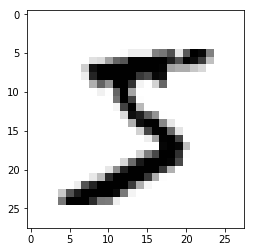

In [6]:
print('图片：')
print(type(train_dataset[0][0]))
print(train_dataset[0][0].shape)
print('标签：')
print(type(train_dataset[0][1]))
print(train_dataset[0][1])

# 可视化展示
plt.figure()
plt.imshow(train_dataset[0][0].reshape([28,28]), cmap=plt.cm.binary)
plt.show()


# ③ 模型选择和开发

<font size=3>
  

我们选用LeNet-5网络结构。

LeNet-5模型源于论文“LeCun Y, Bottou L, Bengio Y, et al. Gradient-based learning applied to document recognition[J]. Proceedings of the IEEE, 1998, 86(11): 2278-2324.”，

论文地址：[https://ieeexplore.ieee.org/document/726791](https://ieeexplore.ieee.org/document/726791)

## 3.1 网络结构定义

### 3.1.1 模型介绍

![](https://ai-studio-static-online.cdn.bcebos.com/f8bcd92f9b6547f49fd26242c442d2558b508bef22f14884bfeca4c8c83d29bf)

**每个阶段用到的Layer**

![](https://ai-studio-static-online.cdn.bcebos.com/ca6285a14ad1403aadc8188921453419a8c0691ca22d4fedabc00014fc9885fe)  

### 3.1.2卷积神经网络
  
从`原始信号`—>`发现边缘和方向`—>`不断抽象`—>`不断抽象`	  

**发展史**
<img src="https://img-blog.csdnimg.cn/20210205112236191.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80NTYyMzA5Mw==,size_16,color_FFFFFF,t_70" width="50%">   
 
#### 3.1.4网络详解
#### 卷积操作
##### 单通道卷积
y = w * x + b （x是输入，y是输出，w是卷积核，b是贝叶斯）  
![](https://img-blog.csdnimg.cn/img_convert/1933c55f1aac081d9bd018bb1ee01f53.png)  
在这里面涉及连个概念，计算和步长  
 
**计算**：
大家找找规律就ok  


<img src="https://img-blog.csdnimg.cn/20210205122057507.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80NTYyMzA5Mw==,size_16,color_FFFFFF,t_70" width="50%">    

  **步长**：
以上图为例：步长就是1，他的间隔就是一个像素（单位），以此类推  

经过计算以后就得到了一个特征提取以后得到的特征核  
**得到的结果大小**
<img src="https://img-blog.csdnimg.cn/20210205123438373.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80NTYyMzA5Mw==,size_16,color_FFFFFF,t_70" width="50%">  
以上面例子为例：  
>w=3(xw)+0(2 * 0)-2(f-w)/1+1=2    
>h=3(xh)+0(2 * 0)-2(f-h)/1+1=2  

所以得到的结果是2 * 2的结果  

##### 多通道卷积
![](https://img-blog.csdnimg.cn/img_convert/071ce3ff52b47e7177614bd6043d7f02.png)  
这里多通道对应的卷积核也是相应维度的，分别计算出对应维度的结果如何把对应位置的加起来就是最后输出的降维结果  
`1101 = 805 + 271 + 25`  
这里三通道的数据经过一个卷积核得到了一个单通道的表示  

##### 多通道输出
![](https://img-blog.csdnimg.cn/img_convert/602a0b74cbf7eacfbe38a8fc246753f0.png)  
通过多个卷积核得到多个特征然后再堆叠得到一个多通道的输出  

##### Batch
卷积核信息不变，卷积操作会多一定的倍数（和样本数有关）。  
 
这个和上面的一样多个输入和多个卷积核通过卷积生成图  

##### 填充操作（ Padding的由来）：
>角落边缘的像素，只被一个过滤器输出所使用，因为它位于这个3×3的区域的一角。但如果是在中间的像素点，就会有许多3×3的区域与之重叠。  
所以那些在角落或者边缘区域的像素点在输出中采用较少，意味着你丢掉了图像边缘位置的许多信息。  
那么出现的一个解决办法就是填充操作，在原图像外围以0进行填充，在不影响特征提取的同时，增加了对边缘信息的特征提取。  
另外一个好处是，我们在做卷积操作时，每经过一次卷积我们的输入图像大小就会变小，最后经过多次卷积可能我们的图像会变得特别小，我们不希望图像变小的话就可以通过填充操作。  

<img src="https://img-blog.csdnimg.cn/img_convert/ba052bf46749a8bce8af98230abf7fd0.png" width="50%">     
  
白话：就是边缘的一些内容有可能就只被收集了一次特征，但是中心的确有多次，那么边上的信息数据就会丢失或者木有那么的清晰，这个是如果填充空白的数据那么就可以比较好的解决问题，  同时可以解决图像变小带来的某些时候不必要的麻烦  

#### 3.1.5池化层
>池化是使用某一位置的相邻输出的总体统计特征代替网络在该位置的输出，其好处是当输入数据做出少量平移时，经过池化函数后的大多数输出还能保持不变。比如：当识别一张图像是否是人脸时，我们需要知道人脸左边有一只眼睛，右边也有一只眼睛，而不需要知道眼睛的精确位置，这时候通过池化某一片区域的像素点来得到总体统计特征会显得很有用。由于池化之后特征图会变得更小，如果后面连接的是全连接层，能有效的减小神经元的个数，节省存储空间并提高计算效率。  

>**池化的作用**
>池化层是特征选择和信息过滤的过程，过程中会损失一部分信息，但是会同时会减少参数和计算量，在模型效果和计算性能之间寻找平衡，随着运算速度的不断提高，慢慢可能会有一些设计上的变化，现在有些网络已经开始少用或者不用池化层。  

<img src="https://img-blog.csdnimg.cn/img_convert/2f71628bf06dc9ab55dc311446be8717.png" width="50%"> 
  
池化的步长和卷积核的大小有关，默认长度为2  
##### 平均池化(Avg Pooling)
> 对邻域内特征点求平均  

* 优缺点：能很好的保留背景，但容易使得图片变模糊  
* 正向传播：邻域内取平均   
* 反向传播：特征值根据领域大小被平均，然后传给每个索引位置  
##### 最大池化(Max Pooling)
> 对邻域内特征点取最大  

* 优缺点：能很好的保留一些关键的纹理特征，现在更多的再使用Max Pooling而很少用Avg Pooling  
* 正向传播：取邻域内最大，并记住最大值的索引位置，以方便反向传播  
* 反向传播：将特征值填充到正向传播中，值最大的索引位置，其他位置补0  

##### 计算结果的大小公示
<img src="https://img-blog.csdnimg.cn/img_convert/a536c057562d21e72a60e39c44401644.png" width="50%">    

<img src="https://img-blog.csdnimg.cn/img_convert/b780176cc92d2d50bb96870b6f3c6cd7.png" width="50%">    
  
#### 3.1.6激活函数
  
##### Sigmoid

<img src="https://img-blog.csdnimg.cn/img_convert/cf3f229a1ae2357dc08961e29486e5f5.png" width="50%">   


##### Tanh

<img src="https://img-blog.csdnimg.cn/img_convert/ff56f140d1feeb1de13aae2cfbc76be4.png" width="50%">   

> Sigmoid和Tanh激活函数有共同的缺点：即在z很大或很小时，梯度几乎为零，因此使用梯度下降优化算法更新网络很慢。  

##### ReLU

<img src="https://img-blog.csdnimg.cn/img_convert/6ca8571514cbbe784a4770aceab234d9.png" width="50%">   
 
> Relu目前是选用比较多的激活函数，但是也存在一些缺点，在z小于0时，斜率即导数为0。  
> 为了解决这个问题，后来也提出来了Leaky Relu激活函数，不过目前使用的不是特别多。  

### 3.1.2 网络结构代码实现1

理解原论文进行的复现实现，因为模型论文出现在1998年，很多技术还不是最新。

In [39]:
import paddle.nn as nn

network = nn.Sequential(
    nn.Conv2D(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),  # C1 卷积层
    nn.Tanh(),
    nn.AvgPool2D(kernel_size=2, stride=2),  # S2 平局池化层
    nn.Sigmoid(),   # Sigmoid激活函数
    nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),  # C3 卷积层
    nn.Tanh(),
    nn.AvgPool2D(kernel_size=2, stride=2),  # S4 平均池化层
    nn.Sigmoid(),  # Sigmoid激活函数
    nn.Conv2D(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0), # C5 卷积层
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(in_features=120, out_features=84), # F6 全连接层
    nn.Tanh(),
    nn.Linear(in_features=84, out_features=10) # OUTPUT 全连接层
)

**模型可视化**

In [41]:
paddle.summary(network, (1, 1, 32, 32))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-44      [[1, 1, 32, 32]]      [1, 6, 28, 28]          156      
    Tanh-13       [[1, 6, 28, 28]]      [1, 6, 28, 28]           0       
 AvgPool2D-27     [[1, 6, 28, 28]]      [1, 6, 14, 14]           0       
  Sigmoid-23      [[1, 6, 14, 14]]      [1, 6, 14, 14]           0       
   Conv2D-45      [[1, 6, 14, 14]]     [1, 16, 10, 10]         2,416     
    Tanh-14      [[1, 16, 10, 10]]     [1, 16, 10, 10]           0       
 AvgPool2D-28    [[1, 16, 10, 10]]      [1, 16, 5, 5]            0       
  Sigmoid-24      [[1, 16, 5, 5]]       [1, 16, 5, 5]            0       
   Conv2D-46      [[1, 16, 5, 5]]       [1, 120, 1, 1]        48,120     
    Tanh-15       [[1, 120, 1, 1]]      [1, 120, 1, 1]           0       
 Flatten-10968    [[1, 120, 1, 1]]         [1, 120]              0       
   Linear-38         [[1, 120]]     

{'total_params': 61706, 'trainable_params': 61706}

### 3.1.3 网络结构代码实现2

应用了截止到现在为止新的技术点实现后的模型，用Sequential写法。

In [45]:
import paddle.nn as nn

network_2 = nn.Sequential(
    nn.Conv2D(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2D(kernel_size=2, stride=2),
    nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2D(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=400, out_features=120),  # 400 = 5x5x16，输入形状为32x32， 输入形状为28x28时调整为256
    nn.Linear(in_features=120, out_features=84),
    nn.Linear(in_features=84, out_features=10)
)

**模型可视化**

In [46]:
paddle.summary(network_2, (1, 1, 28, 28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-49      [[1, 1, 28, 28]]      [1, 6, 28, 28]          60       
    ReLU-13       [[1, 6, 28, 28]]      [1, 6, 28, 28]           0       
 MaxPool2D-13     [[1, 6, 28, 28]]      [1, 6, 14, 14]           0       
   Conv2D-50      [[1, 6, 14, 14]]     [1, 16, 10, 10]         2,416     
    ReLU-14      [[1, 16, 10, 10]]     [1, 16, 10, 10]           0       
 MaxPool2D-14    [[1, 16, 10, 10]]      [1, 16, 5, 5]            0       
 Flatten-10972    [[1, 16, 5, 5]]          [1, 400]              0       
   Linear-43         [[1, 400]]            [1, 120]           48,120     
   Linear-44         [[1, 120]]            [1, 84]            10,164     
   Linear-45         [[1, 84]]             [1, 10]              850      
Total params: 61,610
Trainable params: 61,610
Non-trainable params: 0
----------------------------------------

{'total_params': 61610, 'trainable_params': 61610}

### 3.1.4 网络结构代码实现3

应用了截止到现在为止新的技术点实现后的模型，模型结构和【网络结构代码实现2】一致，用Sub Class写法。

In [47]:
class LeNet(nn.Layer):
    """
    继承paddle.nn.Layer定义网络结构
    """

    def __init__(self, num_classes=10):
        """
        初始化函数
        """
        super(LeNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2D(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),  # 第一层卷积
            nn.ReLU(), # 激活函数
            nn.MaxPool2D(kernel_size=2, stride=2),  # 最大池化，下采样
            nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0), # 第二层卷积
            nn.ReLU(), # 激活函数
            nn.MaxPool2D(kernel_size=2, stride=2) # 最大池化，下采样
        )

        self.fc = nn.Sequential(
            nn.Linear(400, 120),  # 全连接
            nn.Linear(120, 84),   # 全连接
            nn.Linear(84, num_classes) # 输出层
        )

    def forward(self, inputs):
        """
        前向计算
        """
        y = self.features(inputs)
        y = paddle.flatten(y, 1)
        out = self.fc(y)

        return out

network_3 = LeNet()

**模型可视化**

In [48]:
paddle.summary(network_3, (1, 1, 28, 28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-51      [[1, 1, 28, 28]]      [1, 6, 28, 28]          60       
    ReLU-15       [[1, 6, 28, 28]]      [1, 6, 28, 28]           0       
 MaxPool2D-15     [[1, 6, 28, 28]]      [1, 6, 14, 14]           0       
   Conv2D-52      [[1, 6, 14, 14]]     [1, 16, 10, 10]         2,416     
    ReLU-16      [[1, 16, 10, 10]]     [1, 16, 10, 10]           0       
 MaxPool2D-16    [[1, 16, 10, 10]]      [1, 16, 5, 5]            0       
   Linear-46         [[1, 400]]            [1, 120]           48,120     
   Linear-47         [[1, 120]]            [1, 84]            10,164     
   Linear-48         [[1, 84]]             [1, 10]              850      
Total params: 61,610
Trainable params: 61,610
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward

{'total_params': 61610, 'trainable_params': 61610}

### 3.1.4 网络结构代码实现4

直接应用高层API中封装好的LeNet网络接口。  
***  
`paddle.vision.models.LeNet()`:LeNet模型
![在这里插入图片描述](https://img-blog.csdnimg.cn/20210205142451612.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80NTYyMzA5Mw==,size_16,color_FFFFFF,t_70)

In [50]:
network_4 = paddle.vision.models.LeNet(num_classes=10)

### 3.1.4 模型可视化

通过summary接口来查看搭建的网络结构，查看输入和输出形状，以及需要训练的参数信息。

In [52]:
paddle.summary(network_4, (1, 1, 28, 28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-53      [[1, 1, 28, 28]]      [1, 6, 28, 28]          60       
    ReLU-17       [[1, 6, 28, 28]]      [1, 6, 28, 28]           0       
 MaxPool2D-17     [[1, 6, 28, 28]]      [1, 6, 14, 14]           0       
   Conv2D-54      [[1, 6, 14, 14]]     [1, 16, 10, 10]         2,416     
    ReLU-18      [[1, 16, 10, 10]]     [1, 16, 10, 10]           0       
 MaxPool2D-18    [[1, 16, 10, 10]]      [1, 16, 5, 5]            0       
   Linear-49         [[1, 400]]            [1, 120]           48,120     
   Linear-50         [[1, 120]]            [1, 84]            10,164     
   Linear-51         [[1, 84]]             [1, 10]              850      
Total params: 61,610
Trainable params: 61,610
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward

{'total_params': 61610, 'trainable_params': 61610}

# ④ 模型训练和优化

模型配置

* 优化器：随机梯度下滑（SGD）
* 损失函数：交叉熵（cross entropy）
* 评估指标：Accuracy

In [53]:
# 模型封装
model = paddle.Model(network_4)

# 模型配置
model.prepare(paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters()), # 优化器
              paddle.nn.CrossEntropyLoss(), # 损失函数
              paddle.metric.Accuracy()) # 评估指标

# 启动全流程训练
model.fit(train_dataset,  # 训练数据集
          eval_dataset,   # 评估数据集
          epochs=5,       # 训练轮次
          batch_size=64,  # 单次计算数据样本量
          verbose=1)      # 日志展示形式

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/5
step 938/938 [==============================] - loss: 0.0154 - acc: 0.9404 - 9ms/step        
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 157/157 [==============================] - loss: 0.0102 - acc: 0.9752 - 7ms/step         
Eval samples: 10000
Epoch 2/5
step 938/938 [==============================] - loss: 0.0222 - acc: 0.9764 - 9ms/step        
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 157/157 [==============================] - loss: 0.0075 - acc: 0.9835 - 7ms/step           
Eval samples: 10000
Epoch 3/5
step 938/938 [==============================] - loss: 0.0131 - acc: 0.9814 - 9ms/step        
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average

# ⑤ 模型评估

## 5.1 模型评估

In [26]:
result = model.evaluate(eval_dataset, verbose=1)

print(result)

Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 10000/10000 [==============================] - loss: 1.8477e-05 - acc: 0.9857 - 2ms/step         
Eval samples: 10000
{'loss': [1.8477269e-05], 'acc': 0.9857}


## 5.2 模型预测

### 5.2.1 批量预测

使用model.predict接口来完成对大量数据集的批量预测。

In [27]:
# 进行预测操作
result = model.predict(eval_dataset)

Predict begin...
step 10000/10000 [==============================] - 2ms/step        
Predict samples: 10000


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


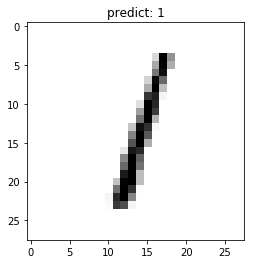

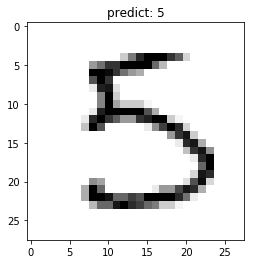

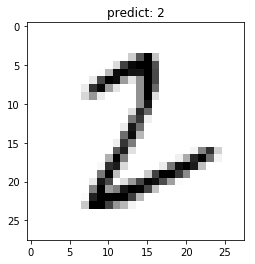

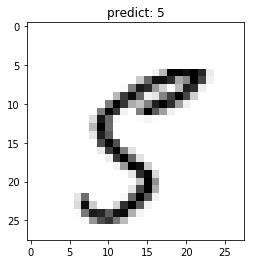

In [28]:
# 定义画图方法
def show_img(img, predict):
    plt.figure()
    plt.title('predict: {}'.format(predict))
    plt.imshow(img.reshape([28, 28]), cmap=plt.cm.binary)
    plt.show()

# 抽样展示
indexs = [2, 15, 38, 211]

for idx in indexs:
    show_img(eval_dataset[idx][0], np.argmax(result[0][idx]))

# ⑥ 部署上线

## 6.1 保存模型

In [29]:
model.save('finetuning/mnist')

## 6.2 继续调优训练

In [33]:
from paddle.static import InputSpec

network = paddle.vision.models.LeNet(num_classes=10)
# 模型封装，为了后面保存预测模型，这里传入了inputs参数
model_2 = paddle.Model(network, inputs=[InputSpec(shape=[-1, 1, 28, 28], dtype='float32', name='image')])

# 加载之前保存的阶段训练模型
model_2.load('finetuning/mnist')

# 模型配置
model_2.prepare(paddle.optimizer.Adam(learning_rate=0.0001, parameters=network.parameters()),  # 优化器
                paddle.nn.CrossEntropyLoss(), # 损失函数
                paddle.metric.Accuracy()) # 评估函数

# 模型全流程训练
model_2.fit(train_dataset,  # 训练数据集
            eval_dataset,   # 评估数据集
            epochs=2,       # 训练轮次
            batch_size=64,  # 单次计算数据样本量
            verbose=1)      # 日志展示形式

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/2
step 938/938 [==============================] - loss: 0.0075 - acc: 0.9935 - 9ms/step         
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 157/157 [==============================] - loss: 8.7727e-05 - acc: 0.9888 - 7ms/step       
Eval samples: 10000
Epoch 2/2
step 938/938 [==============================] - loss: 0.0025 - acc: 0.9945 - 9ms/step         
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 157/157 [==============================] - loss: 9.3565e-05 - acc: 0.9892 - 7ms/step       
Eval samples: 10000


# 6.3 保存预测模型

In [34]:
# 保存用于后续推理部署的模型
model_2.save('infer/mnist', training=False)

<font size=3>
  
  本次项目就到这里了，通过对卷积网络的解析然后通过一个实践最后还是比较好的简述了什么是卷积神经网络，  
  虽然使用的模块还是比较简单的，那我们下次再见！

### 作者简介
> 作者：三岁  
经历：自学python，现在混迹于paddle社区，希望和大家一起从基础走起，一起学习Paddle  
csdn地址：https://blog.csdn.net/weixin_45623093/article/list/3  
我在AI Studio上获得钻石等级，点亮7个徽章，来互关呀~ https://aistudio.baidu.com/aistudio/personalcenter/thirdview/284366 

>传说中的飞桨社区最菜代码人，让我们一起努力！  
记住：三岁出品必是精品 （~~不要脸系列~~）